## Clary Rodriguez-Cruz - Bank Account Fraud Prediction, Spring 2023
Bank account fraud is defined in this context as an attempt to open a bank account with a stolen identity. In this dataset, each instance represents a bank account opening application, some of which are fraudulent applications and some of which are legitimate. Each instance has information on a variety of fields, including customer age, income, phone validity, etc. My goal was to: 

i) Clean and explore the data, 

ii) Train a linear SVM model and evaluate its performance, and 

iii) Determine the most relevant features for predicting whether an application is fraudulent or not.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
plt.style.use('ggplot')

In [32]:
dataset = pd.read_csv('/Users/clary/Documents/Penn/Wharton Analytics/sp23_datachallenge.csv')
dataset.shape
pd.pandas.set_option('display.max_columns', None)
dataset.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,3134.319630,3863.647740,1,6,CA,185,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,2670.918292,3124.298166,718,3,CA,259,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,2893.621498,3159.590679,1,14,CB,177,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,4054.908412,3022.261812,1921,6,CA,110,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,2728.237159,3087.670952,1990,2,CA,295,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


## 1. Exploratory Data Analysis

In [33]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
discrete_features=[feature for feature in numerical_features if len(dataset[feature].unique())<25]
continuous_features=[feature for feature in numerical_features if len(dataset[feature].unique())>=25]
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtypes == 'O']
print("Discrete Variables Count: {}".format(len(discrete_features)))
print("Continuous Variables Count: {}".format(len(continuous_features)))
print("Categorical Variables Count: {}".format(len(categorical_features)))

Discrete Variables Count: 13
Continuous Variables Count: 14
Categorical Variables Count: 5


#### Target Variable

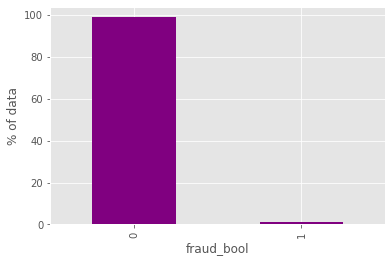

In [34]:
# Check distribution of the independent variable values
target_var = 'fraud_bool'
d=dataset.groupby(target_var)[target_var].count()/np.size(dataset,axis=0)*100
d.plot(kind='bar',color='purple')
plt.ylabel('% of data')
plt.savefig('/Users/clary/Documents/Penn/Wharton Analytics/imbalance.png',bbox_inches='tight',dpi=400)

There is a clear imbalance in the dataset with respect to the target/independent variable, which we will address later on.

#### Missing Values

In [35]:
# Check for missing values
features_missing=[features for features in dataset.columns if dataset[features].isin([-1]).sum()>0]
features_missing.remove('credit_risk_score')

# Check % of missing values (-1)
for feature in features_missing:
    print(feature, np.round(dataset[feature].isin([-1]).mean(), 6),  ' % missing values')

prev_address_months_count 0.71292  % missing values
current_address_months_count 0.004254  % missing values
bank_months_count 0.253635  % missing values
session_length_in_minutes 0.002015  % missing values
device_distinct_emails_8w 0.000359  % missing values


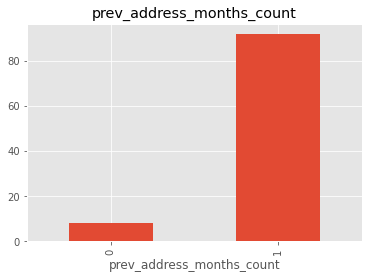

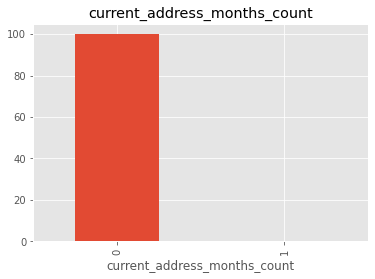

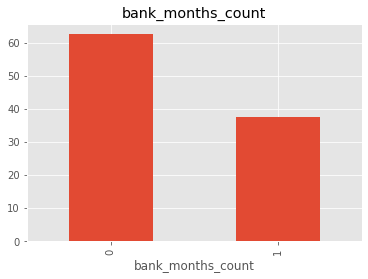

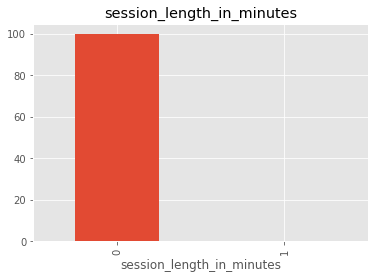

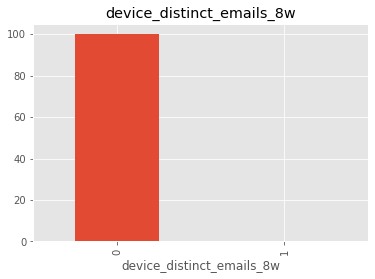

In [36]:
# For each feature with missing values, check what % of the missing and not missing values are fraudulent
for feature in features_missing:
    data = dataset.copy()
    
    # make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isin([-1]), 1, 0)
    
    #  calculate the 'fraud_bool' where the information is missing or present
    d=data.groupby(feature)['fraud_bool'].sum()/np.sum(dataset['fraud_bool']==1)*100
    d.plot(kind='bar')
    plt.title(feature)
    plt.show()

#### Feature Correlations

27

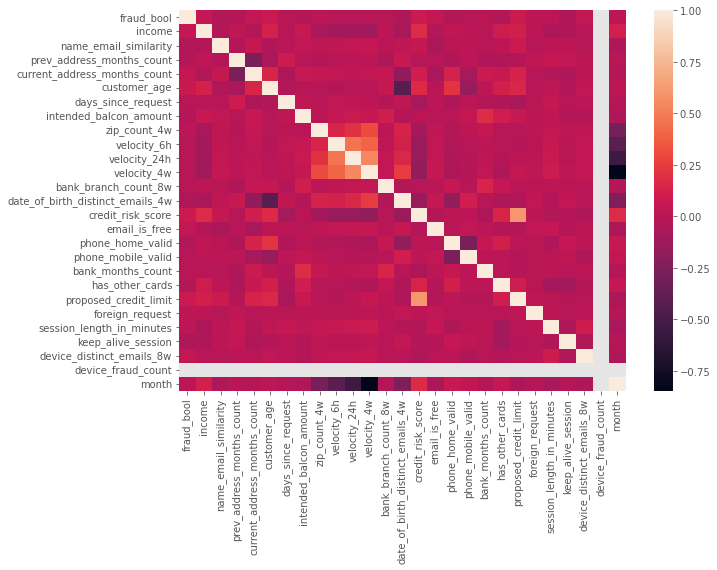

In [37]:
# Calculate correlations between numerical features
data = dataset.copy()
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), annot=False)
data_corr=data.corr()
data_corr.shape[0]

#### Numerical Variables

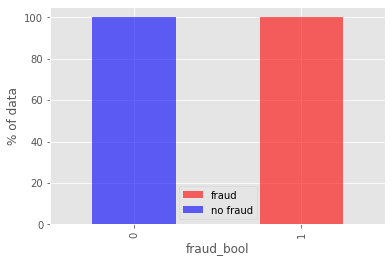

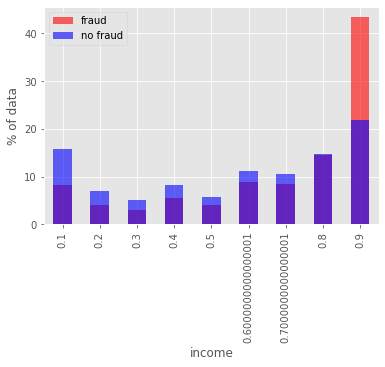

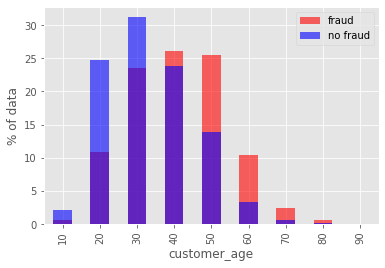

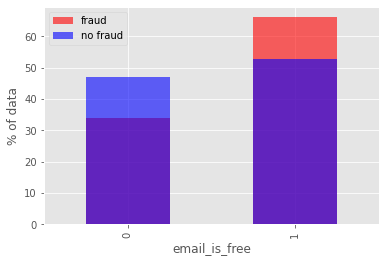

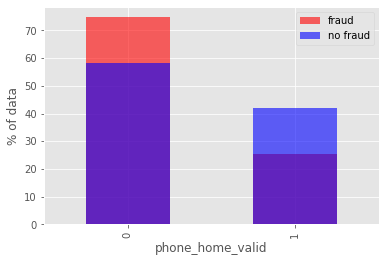

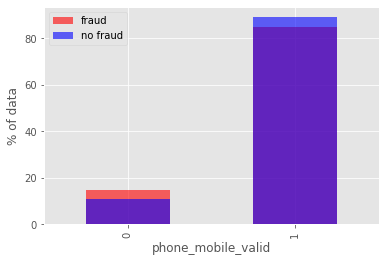

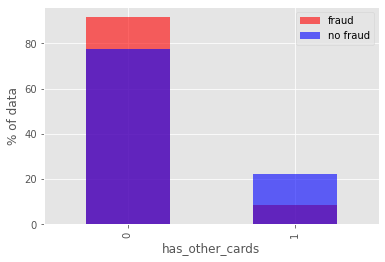

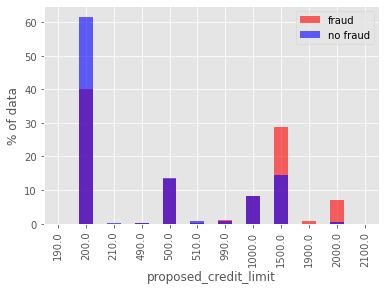

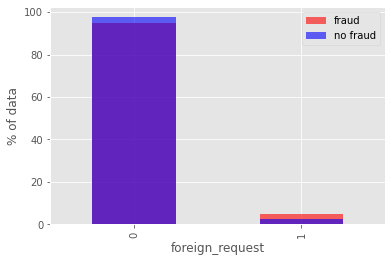

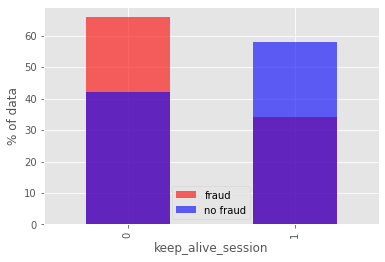

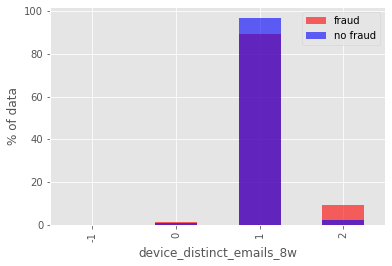

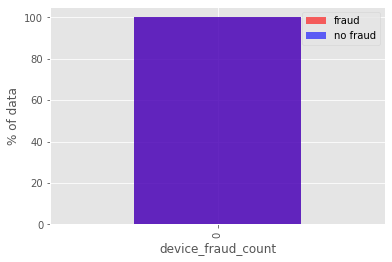

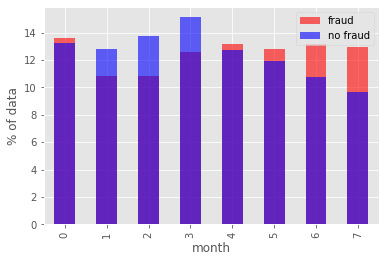

In [38]:
# Discrete features distribution, fraud vs. no fraud
for feature in discrete_features:
    data=dataset.copy()
    data['fraud_bool_inv']=1-data['fraud_bool']
    d=data.groupby(feature)['fraud_bool'].sum()/np.sum(dataset['fraud_bool']==1)*100
    d.plot(kind='bar',alpha=.6,color='red',label='fraud')
    d2=data.groupby(feature)['fraud_bool_inv'].sum()/np.sum(dataset['fraud_bool']==0)*100
    d2.plot(kind='bar',alpha=.6,color='blue',label='no fraud')
    plt.ylabel('% of data')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

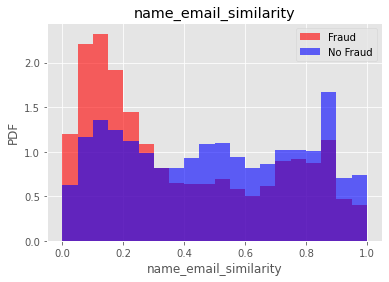

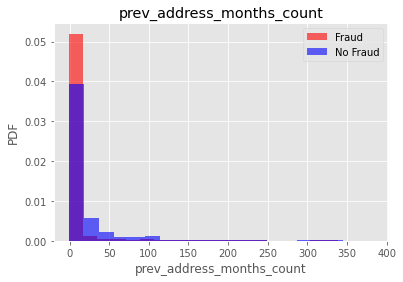

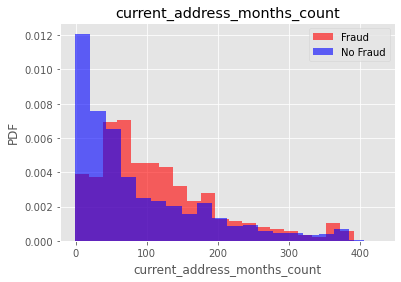

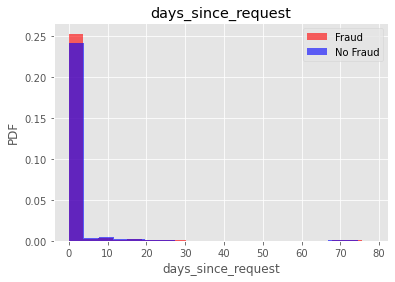

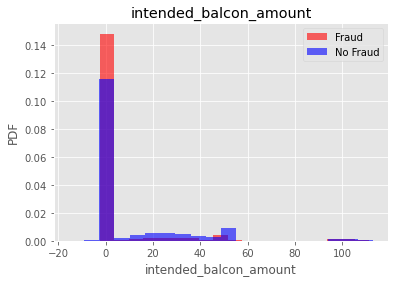

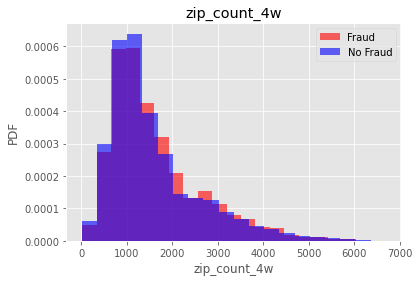

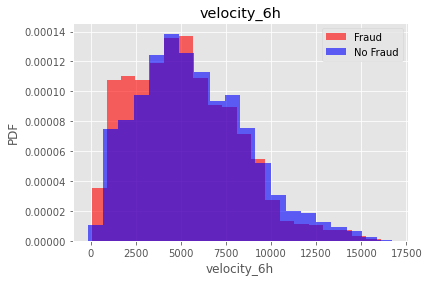

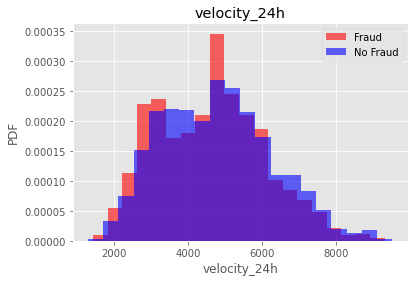

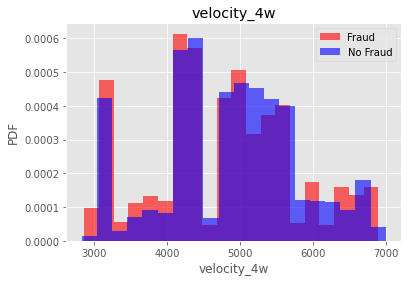

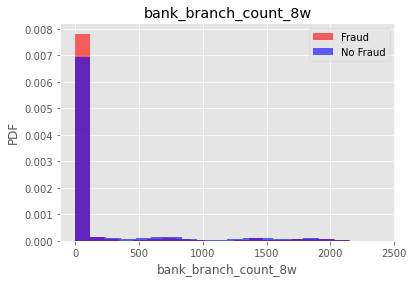

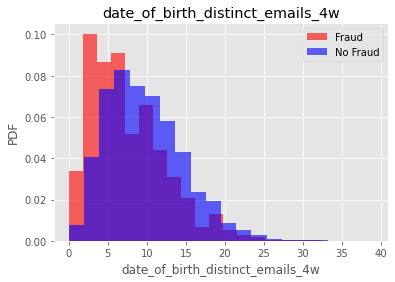

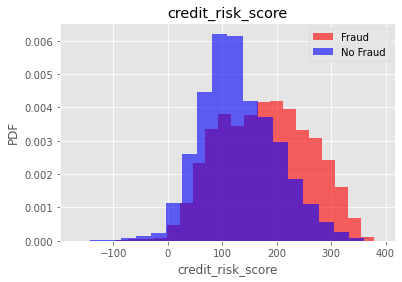

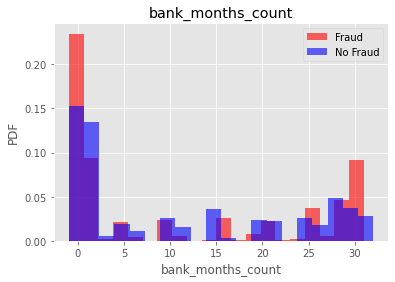

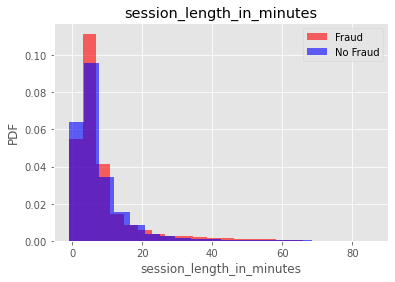

In [39]:
# Continuous features distribution, fraud vs. no fraud
for feature in continuous_features:
    data = dataset.copy()
    p1=data.loc[data['fraud_bool']==1][feature].to_numpy()
    p2=data.loc[data['fraud_bool']==0][feature].to_numpy()
    plt.figure()
    plt.hist(p1,20,density=True,alpha=.6,color='red',label='Fraud')
    plt.hist(p2,20,density=True,alpha=.6,color='blue',label='No Fraud')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('PDF')
    plt.legend()
    plt.show()

#### Categorical Variables

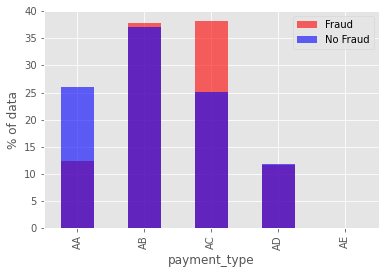

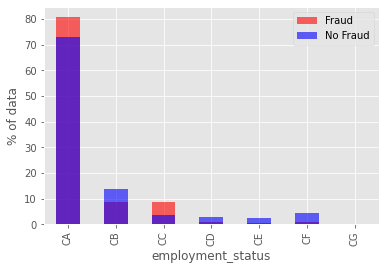

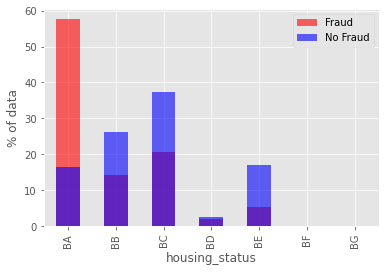

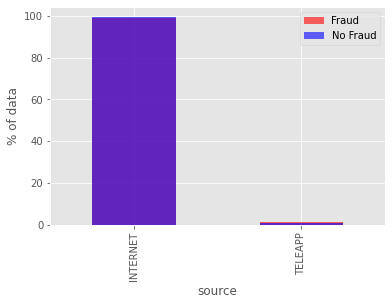

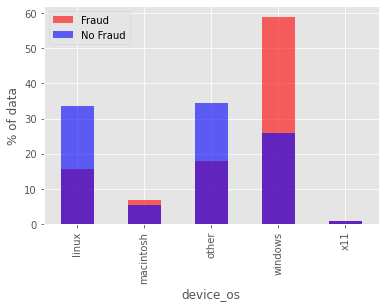

In [40]:
# Categorical features distribution, fraud vs. no fraud
for feature in categorical_features:
    data=dataset.copy()
    data['fraud_bool_inv']=1-data['fraud_bool']
    d=data.groupby(feature)['fraud_bool'].sum()/np.sum(dataset['fraud_bool']==1)*100
    d.plot(kind='bar',alpha=.6,color='red',label='Fraud')
    d2=data.groupby(feature)['fraud_bool_inv'].sum()/np.sum(dataset['fraud_bool']==0)*100
    d2.plot(kind='bar',alpha=.6,color='blue',label='No Fraud')
    plt.ylabel('% of data')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

#### Outliers

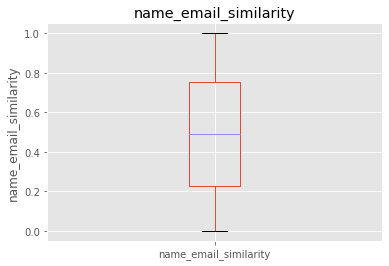

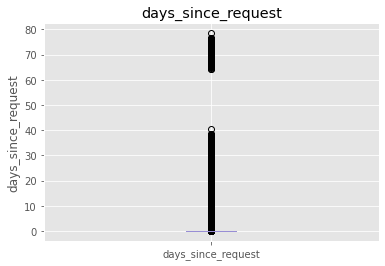

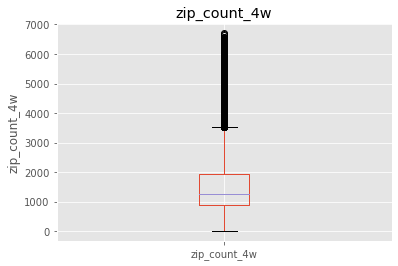

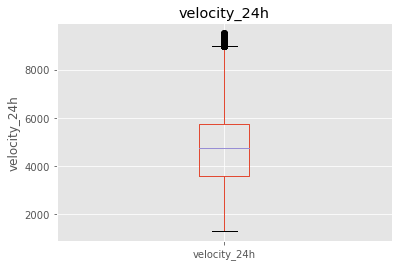

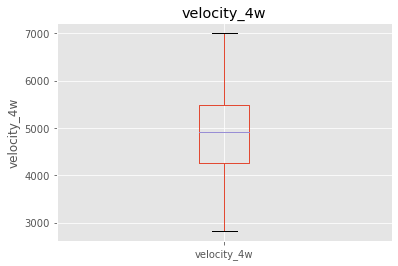

In [41]:
# Box plots of continuous features not containing zeros
for feature in continuous_features:
    data=dataset.copy()
    if np.sum(data[feature]<=0)>0:
        pass
    else:
        data[feature]=data[feature]
        # data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

## 2. Feature Engineering

In [42]:
dataset = pd.read_csv('/Users/clary/Documents/Penn/Wharton Analytics/sp23_datachallenge.csv')

#### Replace Missing Values

In [43]:
data = dataset.copy()

# Create a new feature to capture missing values (only in features with large missing %)
features_missing_add = ['prev_address_months_count','bank_months_count']
for feature in features_missing_add:
    data[feature+'_miss']=np.where(data[feature].isin([-1]),1,0)

# Replace the numerical missing values (we have no missing categorical values)
numerical_missing = [feature for feature in features_missing if data[feature].dtypes!='O']
for feature in numerical_missing:
    # We will replace by using median since there are outliers
    median_val=np.median(np.extract(data[feature]!=-1,data[feature]))
    data[feature]=data[feature].where(data[feature]!=-1,median_val)
    
data[numerical_missing].isin([-1]).sum()

# Remove all 0's feature
data = data.drop('device_fraud_count',axis='columns')

#### Log Transformations (Numerical Features)

In [44]:
# # log transform continuous variables with skewed distributions
# log_features = ['days_since_request','zip_count_4w']
# for feature in log_features:
#     data[feature]=np.log(data[feature])

#### Feature Scaling

In [45]:
from sklearn.preprocessing import OneHotEncoder

for feature in categorical_features:
    # data[feature] = data[feature].astype('category')
    # data[feature] = data[feature].cat.codes
    encoder=OneHotEncoder()
    X = encoder.fit_transform(data[[feature]]).toarray()
    encoder_data = pd.DataFrame(X,columns=[feature+str(int(i)) for i in range(X.shape[1])])
    data = data.join(encoder_data)
    data.drop(feature,axis='columns',inplace=True)

data.head(5)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,prev_address_months_count_miss,bank_months_count_miss,payment_type0,payment_type1,payment_type2,payment_type3,payment_type4,employment_status0,employment_status1,employment_status2,employment_status3,employment_status4,employment_status5,employment_status6,housing_status0,housing_status1,housing_status2,housing_status3,housing_status4,housing_status5,housing_status6,source0,source1,device_os0,device_os1,device_os2,device_os3,device_os4
0,1,0.9,0.166828,34.0,88.0,50,0.020925,-1.331345,769,10650.765523,3134.319630,3863.647740,1,6,185,0,1,0,24.0,0,500.0,0,3.888115,0,1.0,7,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.9,0.296286,34.0,144.0,50,0.005418,-0.816224,366,534.047319,2670.918292,3124.298166,718,3,259,1,0,0,15.0,0,1500.0,0,31.798819,0,1.0,7,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.9,0.044985,34.0,132.0,40,3.108549,-0.755728,870,4048.534263,2893.621498,3159.590679,1,14,177,1,0,1,15.0,0,200.0,0,4.728705,0,1.0,7,1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0.9,0.159511,34.0,22.0,50,0.019079,-1.205124,810,3457.064063,4054.908412,3022.261812,1921,6,110,1,0,1,31.0,1,200.0,0,2.047904,0,1.0,7,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0.9,0.596414,34.0,218.0,50,0.004441,-0.773276,890,5020.341679,2728.237159,3087.670952,1990,2,295,1,1,0,31.0,0,1500.0,0,3.775225,1,1.0,7,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
feature_scale=[feature for feature in data.columns if feature not in ['fraud_bool']]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(data[feature_scale])

scaler.transform(data[feature_scale])

datafin = pd.concat([data[['fraud_bool']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(data[feature_scale]), columns=feature_scale)],
                    axis=1)


## 3. Training Linear Model (Support Vector Machines)

In [47]:
# Undersample the data
from imblearn.under_sampling import RandomUnderSampler
X = datafin.iloc[:,1:]
y = datafin.iloc[:,0]
ros = RandomUnderSampler(random_state=1)
X_res, y_res = ros.fit_resample(X, y)

In [48]:
# Separate data into train/test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.1,random_state=0)
X_train.shape, X_test.shape

((19852, 53), (2206, 53))

In [49]:
# # Linear SVM model - hyperparameter tuning
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, confusion_matrix
# param_grid = {'C': [0.1, 1]} 
# grid = GridSearchCV(LinearSVC(), param_grid, verbose = 3)
# svm_model = grid.fit(X_train,y_train)
# print(grid.best_params_)

# y_pred = svm_model.predict(X_test)
# print(classification_report(y_test, y_pred))


In [50]:
# Linear SVM model - input parameters
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_model=SVC(C=1,kernel='linear')
svm_model=svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1082
           1       0.80      0.80      0.80      1124

    accuracy                           0.80      2206
   macro avg       0.80      0.80      0.80      2206
weighted avg       0.80      0.80      0.80      2206



In [51]:
# Check SVM model accuracy
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.7982774252039891
Precision: 0.803395889186774
Recall: 0.7998220640569395


#### Feature Weights

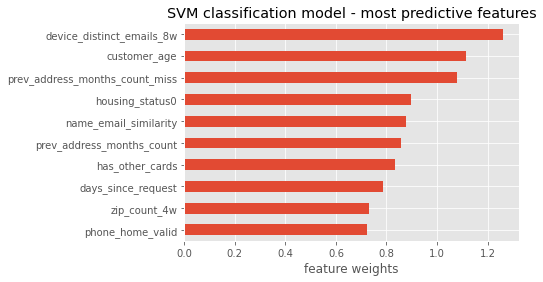

In [52]:
# Get SVM feature weights
weights=svm_model.coef_
w_pos=pd.Series(abs(svm_model.coef_[0]), index=X_train.columns).nlargest(10)
w_neg=pd.Series(-svm_model.coef_[0], index=X_train.columns).nlargest(5)
w_both=pd.concat([w_pos,-w_neg],axis=0)
w_pos.plot(kind='barh').invert_yaxis()
# w_both_idx=w_both.index.tolist()
plt.xlabel('feature weights')
plt.title('SVM classification model - most predictive features')
plt.savefig('/Users/clary/Documents/Penn/Wharton Analytics/pred_features.png',bbox_inches='tight',dpi=400)

The 3 most predictive features in this model are 1- the number of distinct emails used from the same device, 2- the customer's age, and 3- a missing value for the number of months spent in their previous address.

Potential recommendations to the bank (other than utilizing the model to identify fraud) could be to 1- flag applications made from a previously used device and further verify the customer's identity, 2- increase fraud prevention education to customers aged 40+, and 3- make the 'months in previous address' section required, or flag the application for further review if missing.